### >>CL-DA22-5 поток
# Финальный кейс

2017 год. Частный инвестор, неравнодушный к спорту, а в особенности – к футболу, ищет команду аналитиков, способных разгадать код игры ☺
Вам необходимо создать дашборд, который позволит любителю футбола принимать решения, на какую команду делать ставку по конкретному матчу, и убедить его в эффективности алгоритма.
Ваша задача – создать дашборд, который предсказывает результат игры двух футбольных команд в зависимости от ключевых характеристик матча.

### 1. Импорт и подготовка данных

Датасет представляет собой данные европейских футбольных матчей за период с 2008 по 2016 г.

    Загружены и проверены данные для дальнейшего анализа

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import os 
import pandas as pd 

# Работа с базой данных SQL
import sqlite3

# Статистика
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson,skellam

import warnings
warnings.filterwarnings("ignore")


In [88]:
conn = sqlite3.connect('./database.sqlite')

In [89]:
# Загрузка таблицы матчей

query = """
SELECT m.id,
       m.country_id,
       c.name AS country,
       m.league_id,
       l.name AS league,
       m.season,
       m.stage,
       m.date,
       m.match_api_id,
       m.home_team_api_id,
       th.team_short_name AS home_team_short,
       th.team_long_name AS home_team_name,
       m.away_team_api_id,
       ta.team_short_name AS away_team_short,
       ta.team_long_name AS away_team_name,
       m.home_team_goal,
       m.away_team_goal,
       CASE
           WHEN (home_team_goal - away_team_goal) > 0 THEN 'H'
           WHEN (home_team_goal - away_team_goal) < 0 THEN 'A'
           ELSE 'D'
       END AS game_result,
       B365H,
       B365D,
       B365A
  FROM [Match] m
  JOIN [Country] c ON m.country_id = c.id
  JOIN [League] l ON m.league_id = l.id
  JOIN [Team] th ON m.home_team_api_id = th.team_api_id
  JOIN [Team] ta ON m.away_team_api_id = ta.team_api_id
"""

data = pd.read_sql(query, conn)
data

,id,country_id,country,league_id,league,season,stage,date,match_api_id,home_team_api_id,...,home_team_name,away_team_api_id,away_team_short,away_team_name,home_team_goal,away_team_goal,game_result,B365H,B365D,B365A
0,1,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492473,9987,...,KRC Genk,9993,BAC,Beerschot AC,1,1,D,1.73,3.40,5.00
1,2,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492474,10000,...,SV Zulte-Waregem,9994,LOK,Sporting Lokeren,0,0,D,1.95,3.20,3.60
2,3,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492475,9984,...,KSV Cercle Brugge,8635,AND,RSC Anderlecht,0,3,A,2.38,3.30,2.75
3,4,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492476,9991,...,KAA Gent,9998,MON,RAEC Mons,5,0,H,1.44,3.75,7.50
4,5,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492477,7947,...,FCV Dender EH,9985,STL,Standard de Liège,1,3,A,5.00,3.50,1.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,1992091,10190,...,FC St. Gallen,10191,THU,FC Thun,1,0,H,NaN,NaN,NaN
25975,25976,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,1992092,9824,...,FC Vaduz,10199,LUZ,FC Luzern,1,2,A,NaN,NaN,NaN
25976,25977,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,1992093,9956,...,Grasshopper Club Zürich,10179,SIO,FC Sion,2,0,H,NaN,NaN,NaN
25977,25978,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,1992094,7896,...,Lugano,10243,ZUR,FC Zürich,0,0,D,NaN,NaN,NaN


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                25979 non-null  int64  
 1   country_id        25979 non-null  int64  
 2   country           25979 non-null  object 
 3   league_id         25979 non-null  int64  
 4   league            25979 non-null  object 
 5   season            25979 non-null  object 
 6   stage             25979 non-null  int64  
 7   date              25979 non-null  object 
 8   match_api_id      25979 non-null  int64  
 9   home_team_api_id  25979 non-null  int64  
 10  home_team_short   25979 non-null  object 
 11  home_team_name    25979 non-null  object 
 12  away_team_api_id  25979 non-null  int64  
 13  away_team_short   25979 non-null  object 
 14  away_team_name    25979 non-null  object 
 15  home_team_goal    25979 non-null  int64  
 16  away_team_goal    25979 non-null  int64 

In [91]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    #df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [92]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = 'Matches'
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [93]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### 2. Визуализация данных

Распределение данных в столбцах

    Данные в таблице имеют распределение Пуассона
    Выявлена низкая взаимная корреляция

Наиболее важные факторы, влияющие на исход игры, связаны с количеством забитых голов

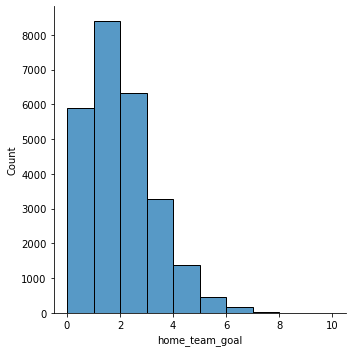

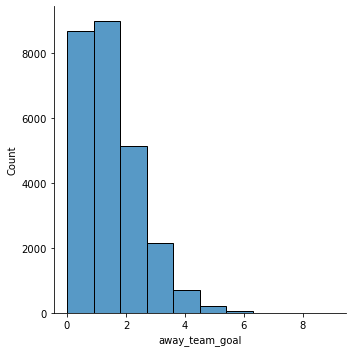

In [94]:
sns.displot(data=data, x='home_team_goal', bins=10)
sns.displot(data=data, x='away_team_goal', bins=10)

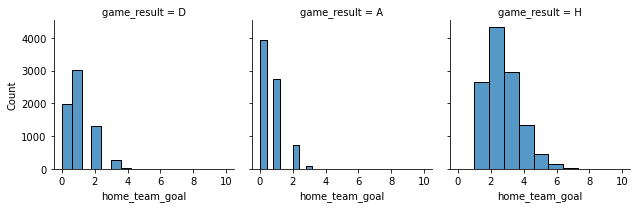

In [95]:
g = sns.FacetGrid(data, col='game_result')
g.map(sns.histplot, "home_team_goal", bins=10)

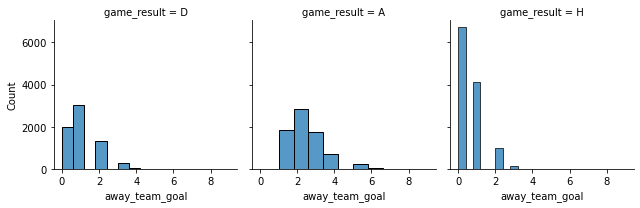

In [96]:
g = sns.FacetGrid(data, col='game_result')
g.map(sns.histplot, "away_team_goal", bins=10)

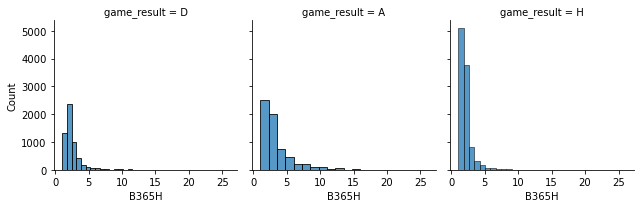

In [97]:
g = sns.FacetGrid(data, col='game_result')
g.map(sns.histplot, "B365H", bins=20)

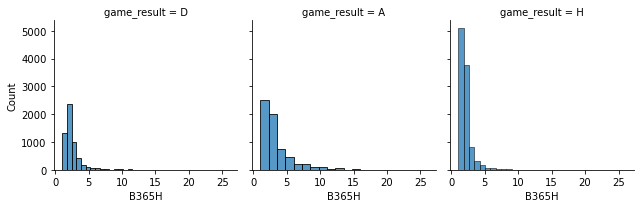

In [98]:
g = sns.FacetGrid(data, col='game_result')
g.map(sns.histplot, "B365H", bins=20)

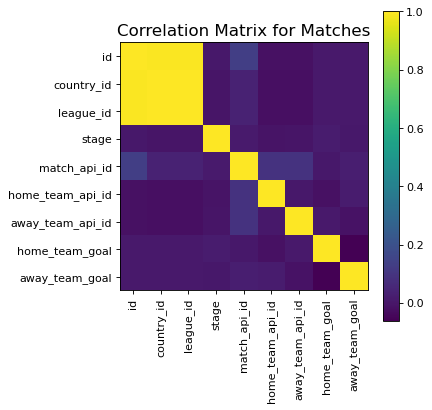

In [99]:
plotCorrelationMatrix(data, 5)

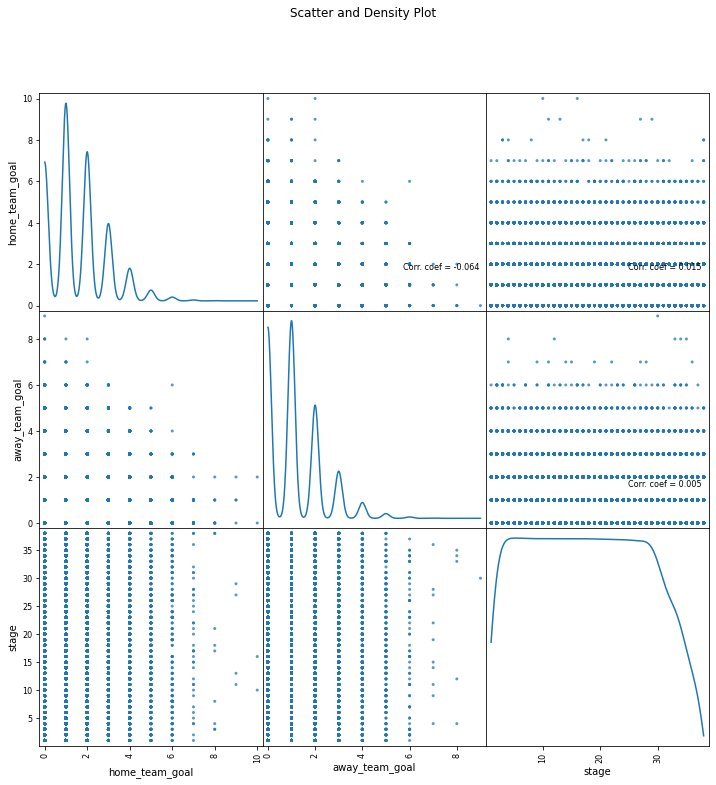

In [100]:
plotScatterMatrix(data[['home_team_goal', 'away_team_goal', 'stage']], 12, 8)

### 3. Получение исторической статистики по командам

Получаем данные на основе подсчета основных параметров 

#### Проверка точности прогноза букмекера

Совпадает ли прогноз с результатом матча?

In [101]:
data['B365H'].fillna(data['B365H'].mean(),inplace=True)
data['B365A'].fillna(data['B365A'].mean(),inplace=True)
data['B365D'].fillna(data['B365D'].mean(),inplace=True)

In [102]:
data = data.assign(home_win_prob = lambda x: 1 / x['B365H'])
data = data.assign(draw_prob = lambda x: 1 / x['B365D'])
data = data.assign(away_win_prob = lambda x: 1 / x['B365A'])
data = data.assign(min_prob = lambda x: x[['home_win_prob','draw_prob','away_win_prob']].min(axis=1))

data['result_prob'] = 0
data['result_copy'] = data['game_result']
#data['is_bk_correct'] = 0

for i in data.index:

    if (data['home_win_prob'][i] == data['min_prob'][i]):
        data['result_prob'][i] = 'H'
    if (data['away_win_prob'][i] == data['min_prob'][i]):
        data['result_prob'][i] = 'A'
    else:
        data['result_prob'][i] = 'D'

data['is_bk_correct'] = np.where((data['result_prob'] == data['result_copy']), 1, 0)

data.drop(columns=['min_prob', 'result_copy'])

,id,country_id,country,league_id,league,season,stage,date,match_api_id,home_team_api_id,...,away_team_goal,game_result,B365H,B365D,B365A,home_win_prob,draw_prob,away_win_prob,result_prob,is_bk_correct
0,1,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492473,9987,...,1,D,1.730000,3.400000,5.000000,0.578035,0.294118,0.200000,A,0
1,2,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492474,10000,...,0,D,1.950000,3.200000,3.600000,0.512821,0.312500,0.277778,A,0
2,3,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492475,9984,...,3,A,2.380000,3.300000,2.750000,0.420168,0.303030,0.363636,D,0
3,4,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492476,9991,...,0,H,1.440000,3.750000,7.500000,0.694444,0.266667,0.133333,A,0
4,5,1,Belgium,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492477,7947,...,3,A,5.000000,3.500000,1.650000,0.200000,0.285714,0.606061,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,1992091,10190,...,0,H,2.628818,3.839684,4.662222,0.380399,0.260438,0.214490,A,0
25975,25976,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,1992092,9824,...,2,A,2.628818,3.839684,4.662222,0.380399,0.260438,0.214490,A,1
25976,25977,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-23 00:00:00,1992093,9956,...,0,H,2.628818,3.839684,4.662222,0.380399,0.260438,0.214490,A,0
25977,25978,24558,Switzerland,24558,Switzerland Super League,2015/2016,9,2015-09-22 00:00:00,1992094,7896,...,0,D,2.628818,3.839684,4.662222,0.380399,0.260438,0.214490,A,0


#### Создание таблицы со статистикой команд

In [103]:
teams = np.unique(data['home_team_name'])
seasons = np.unique(data['season'])
team_performance = pd.DataFrame()
hp_array = np.array([])

goals_scored = 0
wins = 0
draws = 0
loses = 0
total_matches = 0

for i in teams:
    temp_df = {
        'team' : i, 
        'home_goal_scored' : data[(data['home_team_name'] == i)]['home_team_goal'].sum(),
        'home_goal_allowed' : data[(data['home_team_name'] == i)]['away_team_goal'].sum(),
        'home_wins' : len(data[(data['home_team_name'] == i) & (data['game_result'] == 'H')]), 
        'home_draws' : len(data[(data['home_team_name'] == i) & (data['game_result'] == 'D')]), 
        'home_loses' : len(data[(data['home_team_name'] == i) & (data['game_result'] == 'A')]), 
        'total_home_matches' : len(data[(data['home_team_name'] == i)]),
        'away_goal_scored' : data[(data['away_team_name'] == i)]['away_team_goal'].sum(),
        'away_goal_allowed' : data[(data['away_team_name'] == i)]['away_team_goal'].sum(),
        'away_wins' : len(data[(data['away_team_name'] == i) & (data['game_result'] == 'H')]), 
        'away_draws' : len(data[(data['away_team_name'] == i) & (data['game_result'] == 'D')]), 
        'away_loses' : len(data[(data['away_team_name'] == i) & (data['game_result'] == 'A')]), 
        'total_away_matches' : len(data[(data['away_team_name'] == i)]),
        'bk_hist_home_win_prob': data[(data['home_team_name'] == i)]['home_win_prob'].median(),
        'bk_hist_draw_prob': data[(data['home_team_name'] == i)]['draw_prob'].median(),
        'bk_hist_away_win_prob': data[(data['away_team_name'] == i)]['away_win_prob'].median(),
        'bk_accuracy' : len(data[(data['away_team_name'] == i) & data['is_bk_correct'] == 1]) / len(data[(data['home_team_name'] == i)].notnull()),
        }

    team_performance = team_performance.append(temp_df, ignore_index= True)

team_performance['hist_home_win_prob'] = team_performance['home_wins'] / team_performance['total_home_matches']
team_performance['hist_home_draw_prob'] = team_performance['home_draws'] / team_performance['total_home_matches']
team_performance['hist_away_draw_prob'] = team_performance['away_draws'] / team_performance['total_away_matches']
team_performance['hist_away_win_prob'] = team_performance['away_wins'] / team_performance['total_away_matches']

In [104]:
team_performance

,team,home_goal_scored,home_goal_allowed,home_wins,home_draws,home_loses,total_home_matches,away_goal_scored,away_goal_allowed,away_wins,...,away_loses,total_away_matches,bk_hist_home_win_prob,bk_hist_draw_prob,bk_hist_away_win_prob,bk_accuracy,hist_home_win_prob,hist_home_draw_prob,hist_away_draw_prob,hist_away_win_prob
0,1. FC Kaiserslautern,37,47,8,11,15,34,35,35,18,...,9,34,0.400000,0.294118,0.230947,0.323529,0.235294,0.323529,0.205882,0.529412
1,1. FC Köln,116,139,32,31,39,102,110,110,51,...,28,102,0.408333,0.294118,0.234521,0.313725,0.313725,0.303922,0.225490,0.500000
2,1. FC Nürnberg,108,118,30,21,34,85,85,85,44,...,19,85,0.416667,0.294118,0.250000,0.247059,0.352941,0.247059,0.258824,0.517647
3,1. FSV Mainz 05,171,129,55,29,35,119,149,149,50,...,33,119,0.454545,0.294118,0.294118,0.310924,0.462185,0.243697,0.302521,0.420168
4,AC Ajaccio,64,77,16,19,22,57,52,52,30,...,6,57,0.322581,0.322581,0.166667,0.105263,0.280702,0.333333,0.368421,0.526316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Xerez Club Deportivo,20,29,6,4,9,19,18,18,11,...,2,19,0.333333,0.303030,0.166667,0.157895,0.315789,0.210526,0.315789,0.578947
292,Zagłębie Lubin,116,108,35,27,28,90,91,91,42,...,24,90,0.380399,0.260438,0.214490,0.266667,0.388889,0.300000,0.266667,0.466667
293,Zawisza Bydgoszcz,43,38,13,5,12,30,32,32,15,...,6,30,0.380399,0.260438,0.214490,0.200000,0.433333,0.166667,0.300000,0.500000
294,Évian Thonon Gaillard FC,105,103,29,17,30,76,75,75,41,...,16,76,0.400000,0.312500,0.222222,0.210526,0.381579,0.223684,0.250000,0.539474


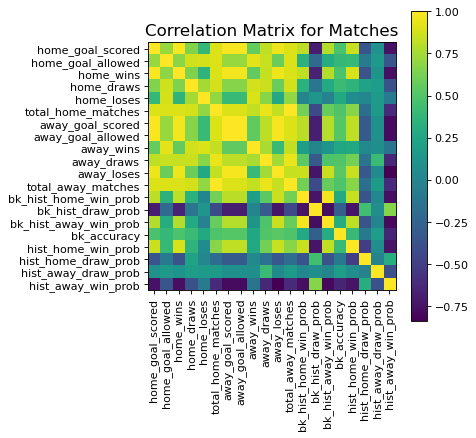

In [105]:
plotCorrelationMatrix(team_performance, 5)

In [80]:
team_performance.to_csv('team_performance.csv')

#### Получение данных за последний сезон для визуализации в Табло

In [83]:
data.dropna(subset = ['home_team_name', 'away_team_name'], inplace = True)
data[(data['season'] == '2015/2016') | (data['season'] == '2014/2015')].to_csv('./2015-16_season_data.csv')

#### Получение аттрибутов команд за последний сезон

In [86]:
query = """
    SELECT DISTINCT 
    home_team_api_id,
    t.team_long_name,
    buildUpPlaySpeed,
    buildUpPlaySpeedClass,
    buildUpPlayDribbling,
    buildUpPlayDribblingClass,
    buildUpPlayPassing,
    buildUpPlayPassingClass,
    buildUpPlayPositioningClass,
    chanceCreationPassing,
    chanceCreationPassingClass,
    chanceCreationCrossing,
    chanceCreationCrossingClass,
    chanceCreationShooting,
    chanceCreationShootingClass,
    chanceCreationPositioningClass,
    defencePressure,
    defencePressureClass,
    defenceAggression,
    defenceAggressionClass,
    defenceTeamWidth,
    defenceTeamWidthClass,
    defenceDefenderLineClass
    FROM [Match] m
    JOIN Team t ON m.home_team_api_id = t.team_api_id
    LEFT JOIN Team_Attributes ta ON m.home_team_api_id = ta.team_api_id
    WHERE season = '2015/2016'
"""

team_attributes = pd.read_sql(query, conn)
team_attributes.to_csv('team_attributes.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   home_team_api_id                919 non-null    int64  
 1   team_long_name                  919 non-null    object 
 2   buildUpPlaySpeed                915 non-null    float64
 3   buildUpPlaySpeedClass           915 non-null    object 
 4   buildUpPlayDribbling            318 non-null    float64
 5   buildUpPlayDribblingClass       915 non-null    object 
 6   buildUpPlayPassing              915 non-null    float64
 7   buildUpPlayPassingClass         915 non-null    object 
 8   buildUpPlayPositioningClass     915 non-null    object 
 9   chanceCreationPassing           915 non-null    float64
 10  chanceCreationPassingClass      915 non-null    object 
 11  chanceCreationCrossing          915 non-null    float64
 12  chanceCreationCrossingClass     915 

### 4. Предиктивная модель. Симуляция матчей

        В соответствии с выявленным характером распределения данных в качестве модели была выбрана регрессия Пуассона

В статистике регрессия Пуассона представляет собой обобщенную линейную модель форма регрессионного анализа , используемая для моделирования данных подсчета и таблиц непредвиденных обстоятельств . Регрессия Пуассона предполагает, что переменная ответа Y имеет распределение Пуассона , и предполагает, что логарифм его ожидаемого значения может быть смоделирован линейной комбинацией неизвестных параметров . Модель регрессии Пуассона иногда известна как лог-линейная модель

Модель учитывает преимущество игры на домашнем поле, команда и оппонент - фиксированные эффекты. Точность модели может варьироваться значительно.

Создается матрица вероятностей возможных исходов матча по количеству забитых мячей.
Из матрицы рассчитывается вероятность победы хозяев, ничьи, победы гостей. 

Итерационно для каждой лиги данные матчей загружаются в модель, затем симулируются все возможные комбинации играющих в лиге команд. Полученные вероятности заносятся в таблицу.

Таблицы для каждой лиги объединяются и образуют общий датафрейм со всеми возможными вариантами команд для каждой лиги и вероятностями победы, ничьи и поражения. 

Исходный код: https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/ 

#### Пример для Английской Премьер Лиги

Пример работы модели на данных Английской Премьер Лига за сезон 2015/2016. 
    
    (Данные для общего датафрейма далее берутся за все доступные сезоны)

In [59]:
query = """
SELECT Match.id,
    League.name AS league_name, 
    season, 
    HT.team_long_name AS  HomeTeam,
    AT.team_long_name AS AwayTeam,
    home_team_goal AS HomeGoals, 
    away_team_goal AS AwayGoals                                        
FROM Match
    JOIN Country on Country.id = Match.country_id
    JOIN League on League.id = Match.league_id
    LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
    LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
WHERE league_id=1729
"""
df = pd.read_sql(query, conn)
df

,id,league_name,season,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,1729,England Premier League,2008/2009,Manchester United,Newcastle United,1,1
1,1730,England Premier League,2008/2009,Arsenal,West Bromwich Albion,1,0
2,1731,England Premier League,2008/2009,Sunderland,Liverpool,0,1
3,1732,England Premier League,2008/2009,West Ham United,Wigan Athletic,2,1
4,1733,England Premier League,2008/2009,Aston Villa,Manchester City,4,2
...,...,...,...,...,...,...,...
3035,4764,England Premier League,2015/2016,Southampton,Leicester City,2,2
3036,4765,England Premier League,2015/2016,Swansea City,Stoke City,0,1
3037,4766,England Premier League,2015/2016,Tottenham Hotspur,Liverpool,0,0
3038,4767,England Premier League,2015/2016,Watford,Arsenal,0,3


In [15]:
goal_model_data = pd.concat([
    df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
    df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})
])
goal_model_data

,team,opponent,goals,home
0,Manchester United,Newcastle United,1,1
1,Arsenal,West Bromwich Albion,1,1
2,Sunderland,Liverpool,0,1
3,West Ham United,Wigan Athletic,2,1
4,Aston Villa,Manchester City,4,1
...,...,...,...,...
3035,Leicester City,Southampton,2,0
3036,Stoke City,Swansea City,1,0
3037,Liverpool,Tottenham Hotspur,0,0
3038,Arsenal,Watford,3,0


In [16]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 6080
Model:                            GLM   Df Residuals:                     6012
Model Family:                 Poisson   Df Model:                           67
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8755.6
Date:                Tue, 22 Nov 2022   Deviance:                       6856.2
Time:                        00:58:06   Pearson chi2:                 5.95e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1506
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2361      0.072      3.285      0.001       0.095       0.377
team[T.Aston Villa]                    -0.5200      0.069     -7.551      0.000      -0.655      -0.385
team[T.Birmingham City]                -0.6651      0.123     -5.404      0.000      -0.906      -0.424
team[T.Blackburn Rovers]               -0.4947      0.087     -5.712      0.000      -0.664      -0.325
team[T.Blackpool]                      -0.2589      0.141     -1.831      0.067      -0.536       0.018
team[T.Bolton Wanderers]               -0.4606      0.085     -5.387      0.000      -0.628      -0.293
team[T.Bournemouth]                    -0.3891      0.155     -2.506      0.012      -0.693      -0.085
team[T.Burnley]                        -0.6877      0.127     -5.426      0.000      -0.936      -0.439
team[T.Cardiff City]                   -0.7529      0.182     -4.141      0.000      -1.109      -0.397
team[T.Chelsea]                         0.0130      0.059      0.220      0.826      -0.103       0.128
team[T.Crystal Palace]                 -0.5493      0.101     -5.438      0.000      -0.747      -0.351
team[T.Everton]                        -0.2626      0.064     -4.135      0.000      -0.387      -0.138
team[T.Fulham]                         -0.4841      0.074     -6.506      0.000      -0.630      -0.338
team[T.Hull City]                      -0.6657      0.093     -7.132      0.000      -0.849      -0.483
team[T.Leicester City]                 -0.1838      0.103     -1.786      0.074      -0.386       0.018
team[T.Liverpool]                      -0.0742      0.060     -1.229      0.219      -0.192       0.044
team[T.Manchester City]                 0.0545      0.058      0.934      0.351      -0.060       0.169
team[T.Manchester United]               0.0105      0.059      0.177      0.859      -0.105       0.126
team[T.Middlesbrough]                  -0.9365      0.194     -4.834      0.000      -1.316      -0.557
team[T.Newcastle United]               -0.4133      0.070     -5.937      0.000      -0.550      -0.277
team[T.Norwich City]                   -0.5498      0.090     -6.137      0.000      -0.725      -0.374
team[T.Portsmouth]                     -0.6867      0.125     -5.481      0.000      -0.932      -0.441
team[T.Queens Park Rangers]            -0.5984      0.102     -5.849      0.000      -0.799      -0.398
team[T.Reading]                        -0.4784      0.158     -3.022      0.003      -0.789      -0.168
team[T.Southampton]                    -0.2537      0.080     -3.167      0.002      -0.411      -0.097
team[T.Stoke City]                     -0.5674      0.070     -8.137      0.000      -0.704      -0.431
team[T.Sunderland]                     -0.5287      0.069     -7.66

In [33]:
home_team='Manchester City'
away_team='Liverpool'


home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'home':0},index=[1]))
print(f'{home_team} against {away_team} expect to score: {round(home_score_rate.to_list()[0],2)}')
print(f'{away_team} against {home_team} expect to score: {round(away_score_rate.to_list()[0],2)}')

Manchester City against Liverpool expect to score: 1.87
Liverpool against Manchester City expect to score: 1.13


In [34]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals):
    
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 'opponent': awayTeam,'home':1}, index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 'opponent': homeTeam,'home':0}, index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [35]:
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

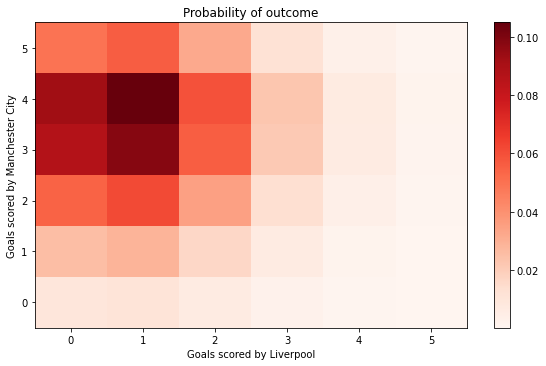

In [36]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(1,1,1)

pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

In [37]:
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))
print(f'Probabilities \n{home_team} win: {round(homewin,2)}, draw: {round(draw,2)}, {away_team} win: {round(awaywin,2)}') 

Probabilities 
Manchester City win: 0.53, draw: 0.23, Liverpool win: 0.23


In [25]:
def create_league_prob_dataframe(data):
    
    from itertools import product
    
    teams_list = {
        'home' : np.unique(data['HomeTeam']),
        'away' : np.unique(data['AwayTeam'])
    }

    league_prob_dataframe = pd.DataFrame()

    for combination in product(*teams_list.values()):
        home_team = combination[0]
        away_team = combination[1]
        max_goals=5
        if (home_team != away_team):
            score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)
            homewin=np.sum(np.tril(score_matrix, -1))
            draw=np.sum(np.diag(score_matrix))
            awaywin=np.sum(np.triu(score_matrix, 1))

            temp_df = {
                'home_team' : home_team,
                'away_team' : away_team,
                'home_win' : round(homewin,2),
                'draw' : round(draw, 2),
                'away_win' : round(awaywin, 2)
            }
            league_prob_dataframe =  league_prob_dataframe.append(temp_df, ignore_index= True)
            #print(f'\n{home_team} win: {round(homewin,2)}, draw: {round(draw,2)}, {away_team} win: {round(awaywin,2)}') 
        #print(combination)
    return league_prob_dataframe

In [ ]:
english_league_prob = create_league_prob_dataframe(df)

#### Симуляция матчей для всех лиг

In [60]:
query = """
SELECT Match.id,
    League.name AS league_name, 
    season, 
    HT.team_long_name AS  HomeTeam,
    AT.team_long_name AS AwayTeam,
    home_team_goal AS HomeGoals, 
    away_team_goal AS AwayGoals                                        
FROM Match
    JOIN Country on Country.id = Match.country_id
    JOIN League on League.id = Match.league_id
    LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
    LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
"""
df = pd.read_sql(query, conn)
df

,id,league_name,season,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,1,Belgium Jupiler League,2008/2009,KRC Genk,Beerschot AC,1,1
1,2,Belgium Jupiler League,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,3,Belgium Jupiler League,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3
3,4,Belgium Jupiler League,2008/2009,KAA Gent,RAEC Mons,5,0
4,5,Belgium Jupiler League,2008/2009,FCV Dender EH,Standard de Liège,1,3
...,...,...,...,...,...,...,...
25974,25975,Switzerland Super League,2015/2016,FC St. Gallen,FC Thun,1,0
25975,25976,Switzerland Super League,2015/2016,FC Vaduz,FC Luzern,1,2
25976,25977,Switzerland Super League,2015/2016,Grasshopper Club Zürich,FC Sion,2,0
25977,25978,Switzerland Super League,2015/2016,Lugano,FC Zürich,0,0


##### Функция создания общего датафрейма вероятности исходов симулируемых матчей

In [80]:
def create_prob_dataframe(df):
    leagues = np.unique(df['league_name'])
    
    prob_dataframe = pd.DataFrame()
    
    for league in leagues:
        print(f'league: {league}')

        goal_model_data = pd.concat([
        df[df['league_name'] == league][['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
        df[df['league_name'] == league][['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})
        ])

        print('Goal model created')

        poisson_model = smf.glm(formula="goals ~ home + team + opponent", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
        #poisson_model.summary()

        print('Poisson model created')

        from itertools import product
    
        teams_list = {
            'home' : np.unique(df[df['league_name'] == league]['HomeTeam']),
            'away' : np.unique(df[df['league_name'] == league]['AwayTeam'])
        }

        league_prob_dataframe = pd.DataFrame()

        for combination in product(*teams_list.values()):
            home_team = combination[0]
            away_team = combination[1]
            max_goals=5
            if (home_team != away_team):
                score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)
                homewin=np.sum(np.tril(score_matrix, -1))
                draw=np.sum(np.diag(score_matrix))
                awaywin=np.sum(np.triu(score_matrix, 1))

                temp_df = {
                    'league' : league,
                    'home_team' : home_team,
                    'away_team' : away_team,
                    'home_win' : round(homewin,2),
                    'draw' : round(draw, 2),
                    'away_win' : round(awaywin, 2)
                }
                league_prob_dataframe =  league_prob_dataframe.append(temp_df, ignore_index= True)

        prob_dataframe = prob_dataframe.append(league_prob_dataframe, ignore_index = True)
    return prob_dataframe

In [81]:
import warnings
warnings.filterwarnings("ignore")

prob_dataframe = create_prob_dataframe(df)

league: Belgium Jupiler League
Goal model created
Poisson model created
league: England Premier League
Goal model created
Poisson model created
league: France Ligue 1
Goal model created
Poisson model created
league: Germany 1. Bundesliga
Goal model created
Poisson model created
league: Italy Serie A
Goal model created
Poisson model created
league: Netherlands Eredivisie
Goal model created
Poisson model created
league: Poland Ekstraklasa
Goal model created
Poisson model created
league: Portugal Liga ZON Sagres
Goal model created
Poisson model created
league: Scotland Premier League
Goal model created
Poisson model created
league: Spain LIGA BBVA
Goal model created
Poisson model created
league: Switzerland Super League
Goal model created
Poisson model created


In [83]:
prob_dataframe.to_csv('english_league.csv')